# Factor Analysis with Automatic Relevance Determination (ARD) and ADVI

This example is based on [Probabilistic Factor Analysis Methods](https://www.cs.helsinki.fi/u/sakaya/tutorial) by [Suleiman A. Khan](https://users.ics.aalto.fi/suleiman/) & [Joseph H. Sakaya](https://www.cs.helsinki.fi/en/people/sakaya).

Up to now we always had to find out the number of dimensions of the sub-space via a procedure like the "scree plot". In this notebook we'll look at Automatic Relevance Determination (ARD) as a way to determin the number of relevant dimensions automatically. You can learn more about Automatic Relevance Determination in chapter 13.7 "Automatic relevance determination (ARD)/sparse Bayesian learning (SBL)" of [Machine Learning: A Probabilistic Perspective](https://www.amazon.com/Machine-Learning-Probabilistic-Perspective-Computation/dp/0262018020).

## Standard python imports

In [1]:
%%capture
%matplotlib inline
import locale
locale.setlocale(locale.LC_ALL, 'C')
import os, timeit, collections

import IPython.display

import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.linalg, pandas as pd, \
    matplotlib.pyplot as plt, matplotlib.dates, xarray as xr, seaborn as sns
    
import readline # https://github.com/ContinuumIO/anaconda-issues/issues/152
%load_ext rpy2.ipython
import rpy2, rpy2.rinterface, rpy2.robjects, rpy2.robjects.packages, rpy2.robjects.lib, rpy2.robjects.lib.grid, \
    rpy2.robjects.lib.ggplot2, rpy2.robjects.pandas2ri, rpy2.interactive.process_revents, \
    rpy2.interactive, rpy2.robjects.lib.grdevices
# rpy2.interactive.process_revents.start()
rpy2.robjects.pandas2ri.activate()

import pymc3 as pm
from theano import tensor as tt
import pystan, pystan.external.pymc.plots

import datetime, time, pytz, dateutil.relativedelta

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(suppress=True)
np.set_printoptions(precision=8)
np.core.arrayprint._line_width = 180

sns.set()

SEED = 42
np.random.seed(SEED)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport fa_basics

## Sample data generation

In [3]:
X, L,_ = fa_basics.build_toy_dataset()

df = pd.DataFrame(X.T, columns=['x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10'])
df.head()

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
0,0.5789,-0.7172,1.4849,0.4836,0.1614,0.6961,1.0573,0.3687,1.2239,0.5746
1,1.4643,0.0542,0.1990,-0.1562,1.3499,-0.4860,0.6667,-0.3078,0.7026,0.0125
2,2.1083,0.4471,0.1619,-0.7498,0.6475,0.7095,0.6008,1.0736,-0.9696,-0.5367
3,0.7378,-0.8622,-0.5964,-0.7825,1.5627,-0.4754,0.2287,-0.5552,-1.3761,-0.9860
4,1.0815,-2.3869,-1.7890,-2.6238,0.7170,-2.2701,-1.4723,-1.2803,-0.8575,-0.4681


## Stan model

As a first go we'll use the model as given in [Probabilistic Factor Analysis Methods](https://www.cs.helsinki.fi/u/sakaya/tutorial) under "2. Principal Component Analysis". $\newcommand{bfvec}[1]{{\bf #1}}$

This is a version of probabilistic principal component analysis (PPCA), which assumes that $\bfvec{\Psi}=\sigma\bfvec{I}$. Later, further down, we'll extend this model to be a FA model.

### Defining the model

The data part of the model looks exactly like in "Factor Analysis via MCMC sampling":

In [4]:
model_string_data = """
data {
    int<lower=1> N;                // Number of samples 
    int<lower=1> D;                // The original dimension; convert Ps to Ds
    int<lower=1> K;                // The latent dimension; convert Ds to Ks
    matrix[N,D] X;                 // The data matrix data matrix of order [N,D]
}
"""

In [5]:
model_string_parameters = """
parameters {
    matrix[N, K] Z; // The latent matrix
    matrix[D, K] L; // The weight matrix
    real<lower=0> tau; // Noise term 
    vector<lower=0>[K] alpha; // ARD prior
}
"""

In [6]:
model_string_transformed_parameters = """
transformed parameters{
    vector<lower=0>[K] t_alpha;
    real<lower=0> t_tau;
    t_alpha = inv(sqrt(alpha));
    t_tau = inv(sqrt(tau));
}
"""

In [7]:
model_string_model = """
model {
    tau ~ gamma(1,1);
    to_vector(Z) ~ normal(0,1);
    alpha ~ gamma(1e-3,1e-3);
    for(k in 1:K) L[,k] ~ normal(0, t_alpha[k]);
    to_vector(X) ~ normal(to_vector(Z*L'), t_tau);
}
"""
model_string = model_string_data + model_string_parameters + \
    model_string_transformed_parameters + model_string_model

What you should notice above is several things.

First of all in the above model we do not take care of identification. Contrast this to our approach in "Factor Analysis via MCMC sampling", where we forced the upper triangular matrix of L to be 0.

<section class="roundedBorder">
__Please note__: the following explanation is my current interpretation, but this might well be wrong! If you know the "real answer" then please let me know.
</section>

My current understanding of why we do not need to take care of model identification is that we will use ADVI (variational inference) and variational inference will help with label switching: variational Bayes is mode seeking. It probably will end up in a different mode whenever we run the code again but the permuted parameters might be similar.

The other thing with VB is that we just have to look at the last converged value of a parameter, since that would describe the posterior whereas I would need to look at the entire chain in normal mcmc which would be plagued with multiple modes.

If the above assumptions are right then the last converged value of the distribution fitted by ADVI should be smaller than the identified model, as in the unrestricted model, we have $2^K$ possible column sign changes and $K!$ column permutations. We should need to mulitply the values of the unconstrained model by $2^K\cdot K!$ in order to get the same "height" of the probability distribution. We can check this below.$\newcommand{bfvec}[1]{{\bf #1}}$

The other thing to notice is that we work here with $\bfvec{L}$ and $\bfvec{Z}$ rather than like in "Factor Analysis via MCMC sampling" with $\bfvec{L}$ and $\bfvec{Q}=\hbox{cov}[x]=\bfvec{L}\bfvec{L}^T+\bfvec{\Psi}$. 

The reason for why we have the choice between these two views is that (as described in 12.1.1 "FA is a low rank parameterization of an MVN" of [Machine Learning: A Probabilistic Perspective](https://www.amazon.com/Machine-Learning-Probabilistic-Perspective-Computation/dp/0262018020)) factor analysis can be seen as a low rank parametrization of a multi-variate normal model.

Equations 12.3 and 12.4 read:
$$
\begin{eqnarray}
p(\bfvec{x_i}\;|\;\pmb{\theta})&=&\int\mathcal{N}(\bfvec{x_i}\;|\;\bfvec{L}\cdot\bfvec{z_i}+\pmb{\mu}, \bfvec{\Psi})\mathcal{N}(\bfvec{z_i}\;|\;\pmb{\mu_0}, \bfvec{\Sigma_0})\hbox{d}\bfvec{z_i}\\
&=&\mathcal{N}(\bfvec{x_i}\;|\;\bfvec{L}\cdot\pmb{\mu_0}+\pmb{\mu}, \bfvec{\Psi}+\bfvec{L}\bfvec{\Sigma_0}\bfvec{L}^T)
\end{eqnarray}
$$
Where $\theta$ stands for all the parameters like $\mu,\Psi,\mu_0,\Sigma_0,L$.

In general we set $\Sigma_0=I$ and we do not lose generality if we set $\mu_0=\mu=0$. In "Factor Analysis via MCMC sampling" we used the second equation and above we used the first equation (actually the first part under the integral).

### Compiling the model

As a next step we compile the model:

In [8]:
%%capture --no-display
sm = None
def compile_stand_model():
    global sm
    sm = pystan.StanModel(model_code=model_string)

t = timeit.Timer(lambda : compile_stand_model()).timeit(number=1) 

In [9]:
print('Time needed for compiling the stan model: {} seconds'.format(t))

Time needed for compiling the stan model: 40.719782969001244 seconds


### Fitting the model

And then we fit the model via ADVI (variational bayes):

In [10]:
N = X.shape[1]
D = L.shape[0]
K = L.shape[1]
(N, D, K)

(300, 10, 3)

In [11]:
data_list = dict(N = N, D = D, K = D, X = X.T)

In [12]:
%%time
fit = sm.vb(data=data_list, algorithm='meanfield', output_samples=10000)

CPU times: user 13.8 s, sys: 572 ms, total: 14.4 s
Wall time: 14.3 s


### Extracting $\bfvec{L}$

And then we need to extract the parameters. The pystan interface of ADVI saves the generated samples on a `tmp` file on the disk. We need to load that file and then extract the parameters from it:

In [13]:
advi_samples_df = pd.read_csv(fit['args']['sample_file'].decode('ascii'), comment='#')
advi_samples_df.head()

,lp__,Z.1.1,Z.2.1,Z.3.1,Z.4.1,Z.5.1,Z.6.1,Z.7.1,Z.8.1,Z.9.1,Z.10.1,Z.11.1,Z.12.1,Z.13.1,Z.14.1,Z.15.1,Z.16.1,Z.17.1,Z.18.1,Z.19.1,Z.20.1,Z.21.1,Z.22.1,Z.23.1,Z.24.1,Z.25.1,Z.26.1,Z.27.1,Z.28.1,Z.29.1,Z.30.1,Z.31.1,Z.32.1,Z.33.1,Z.34.1,Z.35.1,Z.36.1,Z.37.1,Z.38.1,Z.39.1,Z.40.1,Z.41.1,Z.42.1,Z.43.1,Z.44.1,Z.45.1,Z.46.1,Z.47.1,Z.48.1,Z.49.1,Z.50.1,Z.51.1,Z.52.1,Z.53.1,Z.54.1,Z.55.1,Z.56.1,Z.57.1,Z.58.1,Z.59.1,Z.60.1,Z.61.1,Z.62.1,Z.63.1,Z.64.1,Z.65.1,Z.66.1,Z.67.1,Z.68.1,Z.69.1,Z.70.1,Z.71.1,Z.72.1,Z.73.1,Z.74.1,Z.75.1,Z.76.1,Z.77.1,Z.78.1,Z.79.1,Z.80.1,Z.81.1,Z.82.1,Z.83.1,Z.84.1,Z.85.1,Z.86.1,Z.87.1,Z.88.1,Z.89.1,Z.90.1,Z.91.1,Z.92.1,Z.93.1,Z.94.1,Z.95.1,Z.96.1,Z.97.1,Z.98.1,Z.99.1,Z.100.1,Z.101.1,Z.102.1,Z.103.1,Z.104.1,Z.105.1,Z.106.1,Z.107.1,Z.108.1,Z.109.1,Z.110.1,Z.111.1,Z.112.1,Z.113.1,Z.114.1,Z.115.1,Z.116.1,Z.117.1,Z.118.1,Z.119.1,Z.120.1,Z.121.1,Z.122.1,Z.123.1,Z.124.1,Z.125.1,Z.126.1,Z.127.1,Z.128.1,Z.129.1,Z.130.1,Z.131.1,Z.132.1,Z.133.1,Z.134.1,Z.135.1,Z.136.1,Z.137.1,Z.138.1,Z.139.1,Z.140.1,Z.141.1,Z.142.1,Z.143.1,Z.144.1,Z.145.1,Z.146.1,Z.147.1,Z.148.1,Z.149.1,Z.150.1,Z.151.1,Z.152.1,Z.153.1,Z.154.1,Z.155.1,Z.156.1,Z.157.1,Z.158.1,Z.159.1,Z.160.1,Z.161.1,Z.162.1,Z.163.1,Z.164.1,Z.165.1,Z.166.1,Z.167.1,Z.168.1,Z.169.1,Z.170.1,Z.171.1,Z.172.1,Z.173.1,Z.174.1,Z.175.1,Z.176.1,Z.177.1,Z.178.1,Z.179.1,Z.180.1,Z.181.1,Z.182.1,Z.183.1,Z.184.1,Z.185.1,Z.186.1,Z.187.1,Z.188.1,Z.189.1,Z.190.1,Z.191.1,Z.192.1,Z.193.1,Z.194.1,Z.195.1,Z.196.1,Z.197.1,Z.198.1,Z.199.1,Z.200.1,Z.201.1,Z.202.1,Z.203.1,Z.204.1,Z.205.1,Z.206.1,Z.207.1,Z.208.1,Z.209.1,Z.210.1,Z.211.1,Z.212.1,Z.213.1,Z.214.1,Z.215.1,Z.216.1,Z.217.1,Z.218.1,Z.219.1,Z.220.1,Z.221.1,Z.222.1,Z.223.1,Z.224.1,Z.225.1,Z.226.1,Z.227.1,Z.228.1,Z.229.1,Z.230.1,Z.231.1,Z.232.1,Z.233.1,Z.234.1,Z.235.1,Z.236.1,Z.237.1,Z.238.1,Z.239.1,Z.240.1,Z.241.1,Z.242.1,Z.243.1,Z.244.1,Z.245.1,Z.246.1,Z.247.1,Z.248.1,Z.249.1,...,Z.173.10,Z.174.10,Z.175.10,Z.176.10,Z.177.10,Z.178.10,Z.179.10,Z.180.10,Z.181.10,Z.182.10,Z.183.10,Z.184.10,Z.185.10,Z.186.10,Z.187.10,Z.188.10,Z.189.10,Z.190.10,Z.191.10,Z.192.10,Z.193.10,Z.194.10,Z.195.10,Z.196.10,Z.197.10,Z.198.10,Z.199.10,Z.200.10,Z.201.10,Z.202.10,Z.203.10,Z.204.10,Z.205.10,Z.206.10,Z.207.10,Z.208.10,Z.209.10,Z.210.10,Z.211.10,Z.212.10,Z.213.10,Z.214.10,Z.215.10,Z.216.10,Z.217.10,Z.218.10,Z.219.10,Z.220.10,Z.221.10,Z.222.10,Z.223.10,Z.224.10,Z.225.10,Z.226.10,Z.227.10,Z.228.10,Z.229.10,Z.230.10,Z.231.10,Z.232.10,Z.233.10,Z.234.10,Z.235.10,Z.236.10,Z.237.10,Z.238.10,Z.239.10,Z.240.10,Z.241.10,Z.242.10,Z.243.10,Z.244.10,Z.245.10,Z.246.10,Z.247.10,Z.248.10,Z.249.10,Z.250.10,Z.251.10,Z.252.10,Z.253.10,Z.254.10,Z.255.10,Z.256.10,Z.257.10,Z.258.10,Z.259.10,Z.260.10,Z.261.10,Z.262.10,Z.263.10,Z.264.10,Z.265.10,Z.266.10,Z.267.10,Z.268.10,Z.269.10,Z.270.10,Z.271.10,Z.272.10,Z.273.10,Z.274.10,Z.275.10,Z.276.10,Z.277.10,Z.278.10,Z.279.10,Z.280.10,Z.281.10,Z.282.10,Z.283.10,Z.284.10,Z.285.10,Z.286.10,Z.287.10,Z.288.10,Z.289.10,Z.290.10,Z.291.10,Z.292.10,Z.293.10,Z.294.10,Z.295.10,Z.296.10,Z.297.10,Z.298.10,Z.299.10,Z.300.10,L.1.1,L.2.1,L.3.1,L.4.1,L.5.1,L.6.1,L.7.1,L.8.1,L.9.1,L.10.1,L.1.2,L.2.2,L.3.2,L.4.2,L.5.2,L.6.2,L.7.2,L.8.2,L.9.2,L.10.2,L.1.3,L.2.3,L.3.3,L.4.3,L.5.3,L.6.3,L.7.3,L.8.3,L.9.3,L.10.3,L.1.4,L.2.4,L.3.4,L.4.4,L.5.4,L.6.4,L.7.4,L.8.4,L.9.4,L.10.4,L.1.5,L.2.5,L.3.5,L.4.5,L.5.5,L.6.5,L.7.5,L.8.5,L.9.5,L.10.5,L.1.6,L.2.6,L.3.6,L.4.6,L.5.6,L.6.6,L.7.6,L.8.6,L.9.6,L.10.6,L.1.7,L.2.7,L.3.7,L.4.7,L.5.7,L.6.7,L.7.7,L.8.7,L.9.7,L.10.7,L.1.8,L.2.8,L.3.8,L.4.8,L.5.8,L.6.8,L.7.8,L.8.8,L.9.8,L.10.8,L.1.9,L.2.9,L.3.9,L.4.9,L.5.9,L.6.9,L.7.9,L.8.9,L.9.9,L.10.9,L.1.10,L.2.10,L.3.10,L.4.10,L.5.10,L.6.10,L.7.10,L.8.10,L.9.10,L.10.10,tau,alpha.1,alpha.2,alpha.3,alpha.4,alpha.5,alpha.6,alpha.7,alpha.8,alpha.9,alpha.10,t_alpha.1,t_alpha.2,t_alpha.3,t_alpha.4,t_alpha.5,t_alpha.6,t_alpha.7,t_alpha.8,t_alpha.9,t_alpha.10,t_tau
0,0,-0.2703,0.3461,-0.8149,0.5686,1.1548,0.1892,-0.7183,-0.2416,-0.6241,-0.0513,-1.0103,-1.0203,-0.5061,0.3414,-1.4506,0.2701,-0.8241,0.0288,0

In [14]:
advi_trade_series = advi_samples_df.mean(axis=0)
advi_trade_series.head()

lp__     0.0000
Z.1.1   -0.2654
Z.2.1    0.3606
Z.3.1   -0.8177
Z.4.1    0.5692
dtype: float64

In [15]:
loadings = fa_basics.extract(advi_trade_series, startswith='L.', shape=(D,D))
loadings

array([[ 0.08722363,  0.00338549, -0.03615624, -0.7530561 ,  0.01492748, -0.01816314, -0.1990522 , -0.02551407,  0.08182176,  0.03165268],
       [ 0.03992628,  0.05545036, -0.01641482,  0.27159856, -0.00472041, -0.02583969, -0.80199703, -0.01185525,  0.07828568,  0.00979896],
       [ 0.05893992,  0.0270674 , -0.02868988, -0.10265058, -0.01671362, -0.00992645, -0.10451401, -0.00050824,  0.81923245,  0.00977805],
       [ 0.01760042, -0.00713055,  0.01116759,  0.26868347,  0.00135631, -0.00377025, -0.25264072,  0.00860455,  0.79048333,  0.02791455],
       [-0.04712854,  0.01597312, -0.01582421, -0.60807691,  0.01427967,  0.02537644, -0.23003539,  0.0064922 ,  0.02332382,  0.00274283],
       [ 0.02240381, -0.02154319,  0.01667276,  0.19906262,  0.00364752,  0.01902562, -0.31291389, -0.0373932 ,  0.79054636,  0.01428239],
       [ 0.02852752,  0.00779695, -0.01395481, -0.35753198, -0.0269819 ,  0.03106899, -0.001663  ,  0.01656626,  0.77636092, -0.00502839],
       [-0.66438736, -0.025

#### Visualizing $\bfvec{L}$

Below we will visualize the $L$ matrix. We use a [diverging colour map](https://matplotlib.org/examples/color/colormaps_reference.html) so that zeros are more or less white. Like that you can see which column vectors are substantially different from 0.

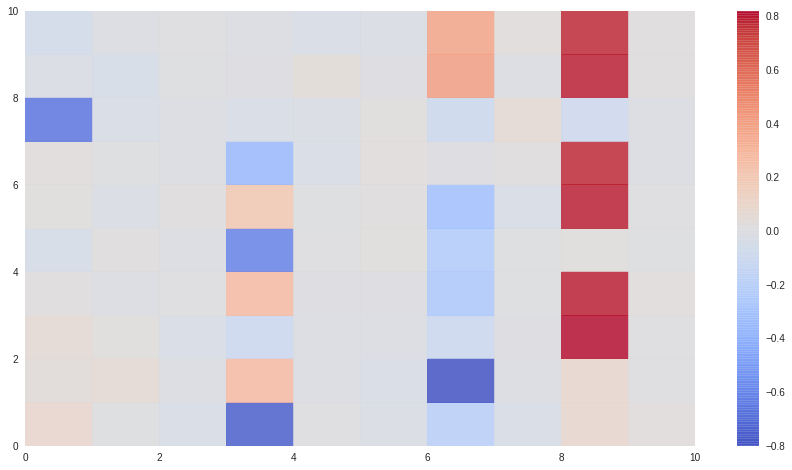

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
im = ax.pcolor(loadings, cmap=plt.cm.coolwarm, alpha=0.8,vmin=loadings.min(),vmax=loadings.max())
fig.colorbar(im);

#### Extracting relevant columns from $L$

The next step is to extract relevant columns from $L$. Relevant means that the columns are substantially different from zero.

The first idea that comes to mind is to use the ARD parameters `alpha`:

In [17]:
fa_basics.extract(advi_trade_series, startswith='alpha.', shape=(D,))

array([  18.37145697,  862.01152955,  672.94098487,    8.62610032,  806.31813469,  851.32468013,    8.53786179,  815.11768123,    2.92767563,  716.54692851])

We could filter on values that are below 15 or so. That actually looks like a good approach.

Another idea would be to look at the 1-norm or the 2-norm of the column vectors and discard column vectors that are too small:

In [18]:
scipy.linalg.norm(loadings, ord=1, axis=0)

array([ 1.05404717,  0.21968947,  0.16789219,  2.6060142 ,  0.17337367,  0.17583765,  2.78276102,  0.206817  ,  5.01819993,  0.14741933])

In [19]:
scipy.linalg.norm(loadings, ord=2, axis=0)

array([ 0.68026477,  0.08522843,  0.05952814,  1.12326843,  0.06705779,  0.06278963,  1.107688  ,  0.08266724,  1.94417174,  0.05429976])

But the differences are not that pronounced and it would not be clear how to exactly decide which columns to take and which not to take?

Again another idea is to count the elements in each column that are substantially different from zero:

In [20]:
scale = np.max(loadings) - np.min(loadings)
scale

1.6212294802519751

In [21]:
np.sum(np.invert(np.isclose(0,loadings,atol=scale*0.1)),axis=0)

array([1, 0, 0, 6, 0, 0, 7, 0, 6, 0])

We then could say that we only keep columns with more than 2 elements different from zero:

In [22]:
loadings[:,np.sum(np.invert(np.isclose(0,loadings,atol=scale*0.1)),axis=0)>2]

array([[-0.7530561 , -0.1990522 ,  0.08182176],
       [ 0.27159856, -0.80199703,  0.07828568],
       [-0.10265058, -0.10451401,  0.81923245],
       [ 0.26868347, -0.25264072,  0.79048333],
       [-0.60807691, -0.23003539,  0.02332382],
       [ 0.19906262, -0.31291389,  0.79054636],
       [-0.35753198, -0.001663  ,  0.77636092],
       [-0.0256346 , -0.09342853, -0.08640914],
       [-0.00351123,  0.40960174,  0.79244377],
       [-0.01620815,  0.37691452,  0.77929271]])

And finally we could evaluate the fit via the principal angles as follows:

In [23]:
180.0*fa_basics.calc_principal_angles(
    L, loadings[:,np.sum(np.invert(np.isclose(0,loadings,atol=scale*0.1)),axis=0)>2])/np.pi

array([ 2.10397839,  5.80069993,  6.66138534])

Not too bad. But several comments:

1. The above model is a PPCA model and not a FA model, e.g. they cannot be compared 1-to-1.
1. Most likely the better approach would be to use this ARD model to identify the number of relevant dimensions and then fit the model again with K=dimensions. Then you would force to find the best parameters for these remaining columns rather than simply discarding the values in the other columns.
1. We also have to keep in mind what happened in "Factor Analysis via MCMC sampling", where with more data the fit became really bad. The question remains how we could evaluate the quality of the fit in an ADVI model? In MCMC there are some metrics like $\hat R$ or the visual examination of the traces. How do you deal with this in ADVI?

# Improvements on the model

Let's see if we can do better and combine the model from "Factor Analysis via MCMC sampling" with ARD.

In [24]:
# Vectors and matrices, as well as arrays, are indexed starting from one in Stan.
model_string_m2 = """
data {
  int<lower=1> N;                // Number of samples 
  int<lower=1> D;                // The original dimension; convert Ps to Ds
  int<lower=1> K;                // The latent dimension; convert Ds to Ks
  matrix[N,D] X;                 // The data matrix data matrix of order [N,D]
}
transformed data {
  int<lower=1> M;
  vector[D] mu;
  M  = K*(D-K)+ K*(K-1)/2;  // number of non-zero loadings
  mu = rep_vector(0.0,D);
}
parameters {    
  vector[M]          L_t;   // lower diagonal elements of L
  vector<lower=0>[K] L_d;   // Diagonal elements of L
  vector<lower=0>[D] psi;   // vector of variances
  real<lower=0>      mu_psi;
  real<lower=0>      sigma_psi;
  vector<lower=0>[K] alpha; // ARD prior
}
transformed parameters{
    vector<lower=0>[K] t_alpha;
    cholesky_factor_cov[D,K] L;  //lower triangular factor loadings Matrix 
    cov_matrix[D]            Q;  //Covariance mat
    
    t_alpha = inv(sqrt(alpha));
    {
      int idx1 = 0;
      int idx2 = 0;
      real zero = 0.0;
   
      for(i in 1:D){
        for(j in (i+1):K){
          idx1 = idx1 + 1;
          L[i,j] = zero; //constrain the upper triangular elements to zero 
        }
      }
      for (j in 1:K) {
        L[j,j] = L_d[j];
        for (i in (j+1):D) {
          idx2 = idx2 + 1;
          L[i,j] = L_t[idx2];
        } 
      }
    } 
    Q = L*L'+diag_matrix(psi); 
}
model {
    // the hyperpriors 
    alpha ~ gamma(1e-3,1e-3);
    mu_psi ~ cauchy(0, 1);
    sigma_psi ~ cauchy(0,1);
    // the priors
    for(k in 1:K) L_d[k] ~ normal(0, t_alpha[k]);
    {
        int idx2 = 0;
        for (k in 1:K) {
            for (i in (k+1):D) {
                idx2 = idx2 + 1;
                L_t[idx2] ~ normal(0, t_alpha[k]);
            } 
        }
    }
    psi ~ cauchy(mu_psi,sigma_psi);
    //The likelihood
    for( j in 1:N)
        X[j] ~ multi_normal(mu,Q); 
    }
"""

In [25]:
%%capture --no-display
sm2 = None
def compile_stand_model():
    global sm2
    sm2 = pystan.StanModel(model_code=model_string_m2)

t = timeit.Timer(lambda : compile_stand_model()).timeit(number=1) 

In [26]:
print('Time needed for compiling the stan model: {} seconds'.format(t))

Time needed for compiling the stan model: 43.989897719999135 seconds


In [27]:
Kused = D
M = int(Kused*(D-Kused)+ Kused*(Kused-1)/2)

def initfun():
    return dict(L_t       = np.zeros(M) + stats.uniform.rvs(loc=-0.1,scale=+0.1),
                L_d       = np.full(Kused, 0.5) + stats.uniform.rvs(loc=-0.1,scale=+0.1),
                psi       = np.full(D, 0.2) + stats.uniform.rvs(loc=-0.1,scale=+0.1),
                sigma_psi = 0.15 + stats.uniform.rvs(loc=-0.1,scale=+0.1),
                mu_psi    = 0.2  + stats.uniform.rvs(loc=-0.1,scale=+0.1))

# initfun()
# will take 3 minutes for 6 chains and 1200 samples
Nchains = 6
Niter   = 1200

In [28]:
# data_list

In [29]:
%%time
fit2 = sm2.sampling(data=data_list, iter=Niter, chains=Nchains, thin=1, seed=SEED, init=initfun, 
                  algorithm='NUTS', pars=["L","psi","sigma_psi","mu_psi","alpha"]) # warmup=100,

CPU times: user 144 ms, sys: 256 ms, total: 400 ms
Wall time: 3min


We will need to run the MCMC for quite a long chain of 1200 iterations until the `Rhat` metric and the visual inspection of the chains looks good. With shorter chains the MCMC algorithm does not converge properly.

In [30]:
print(fit2)

Inference for Stan model: anon_model_bba8da99499f441f95c4aaed237b3064.
6 chains, each with iter=1200; warmup=600; thin=1; 
post-warmup draws per chain=600, total post-warmup draws=3600.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L[0,0]       0.9  9.3e-4   0.05   0.81   0.87    0.9   0.93    1.0   2843    1.0
L[1,0]      0.04  1.2e-3   0.06  -0.09 1.2e-4   0.04   0.08   0.17   2971    1.0
L[2,0]      0.18  1.7e-3   0.06   0.05   0.14   0.17   0.22   0.29   1336    1.0
L[3,0]     -0.07  1.7e-3   0.06   -0.2  -0.11  -0.07  -0.03   0.05   1453    1.0
L[4,0]      0.69  1.4e-3   0.05   0.58   0.65   0.68   0.72    0.8   1367    1.0
L[5,0]     -0.07  1.6e-3   0.06   -0.2  -0.11  -0.07  -0.03   0.05   1453    1.0
L[6,0]      0.43  1.6e-3   0.06   0.31   0.39   0.43   0.47   0.55   1479    1.0
L[7,0]     -0.01  9.7e-4   0.06  -0.13  -0.05  -0.01   0.03    0.1   3600    1.0
L[8,0]     -0.12  1.6e-3   0.06  -0.25  -0.17  -0.12  -0.08 2.2e-3   1663    1.0
L[9

In [31]:
fit_extracted = fit2.extract(permuted=False)
surrogate_trace = collections.OrderedDict(
    [(fname, fit_extracted[:,:,i]) for i, fname in enumerate(fit2.sim['fnames_oi'])])

/home/user/cs/local/install/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  if __name__ == '__main__':


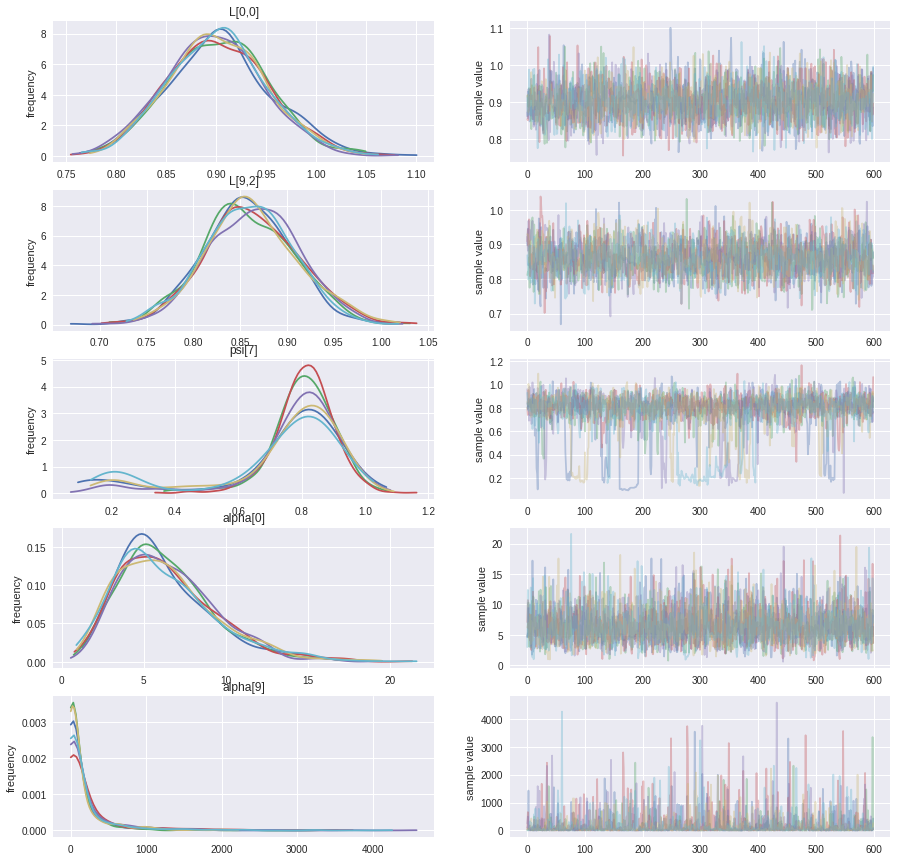

In [32]:
from scipy.stats import kde
def kdeplot_op(ax, data):
    data = np.atleast_2d(data.T).T
    for i in range(data.shape[1]):
        d = data[:, i]
        density = kde.gaussian_kde(d)
        l = np.min(d)
        u = np.max(d)
        x = np.linspace(0, 1, 100) * (u - l) + l

        ax.plot(x, density(x))

vars=['L[0,0]', 'L[9,2]', 'psi[7]', 'alpha[0]', 'alpha[9]']
n = len(vars)
f, ax = plt.subplots(n, 2, squeeze=False, figsize=(15,15))
#fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

for i, v in enumerate(vars):
    d = np.squeeze(surrogate_trace[v])

    if surrogate_trace[v].dtype.kind == 'i':
        ax[i, 0].hist(d, bins=sqrt(d.size))
    else:
        kdeplot_op(ax[i, 0], d)
    ax[i, 0].set_title(str(v))
    ax[i, 1].plot(d, alpha=.35)

    ax[i, 0].set_ylabel("frequency")
    ax[i, 1].set_ylabel("sample value")

In [33]:
surrogate_trace_means = [(key, np.mean(vals)) for key, vals in surrogate_trace.items()]
surrogate_trace_df = pd.DataFrame(surrogate_trace_means, columns=['name', 'value'])
surrogate_trace_df.set_index('name',inplace=True)

In [34]:
psis = fa_basics.extract(surrogate_trace_df['value'], startswith='psi', shape=[L.shape[0]])
np.sort(psis)

array([ 0.14959962,  0.15171287,  0.18089489,  0.18523634,  0.18840041,  0.18955207,  0.19900024,  0.209047  ,  0.38164062,  0.76202387])

In [35]:
original_psi = np.array([0.2079, 0.19, 0.1525, 0.20, 0.36, 0.1875, 0.1875, 1.00, 0.27, 0.27])
np.sort(original_psi)

array([ 0.1525,  0.1875,  0.1875,  0.19  ,  0.2   ,  0.2079,  0.27  ,  0.27  ,  0.36  ,  1.    ])

In [36]:
loadings_m2 = fa_basics.extract(surrogate_trace_df['value'], startswith='L', shape=(D,D))
loadings_m2

array([[ 0.90158014,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.04135276,  0.90190546,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.17567477,  0.16404415,  0.87451243,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.07248948,  0.40872751,  0.83573173,  0.04936735,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.68577325,  0.02204106, -0.00549393,  0.00914721,  0.08470864,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.07069945,  0.46127487,  0.77639467,  0.00472866,  0.01607427,  0.04775074,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.4301954 , -0.01898762,  0.79878126,  0.01412052,  0.01167114, -0.01230274,  0.0657702 ,  0.        ,  0.        ,  0.        ],
       [-0.01154369,  0.040

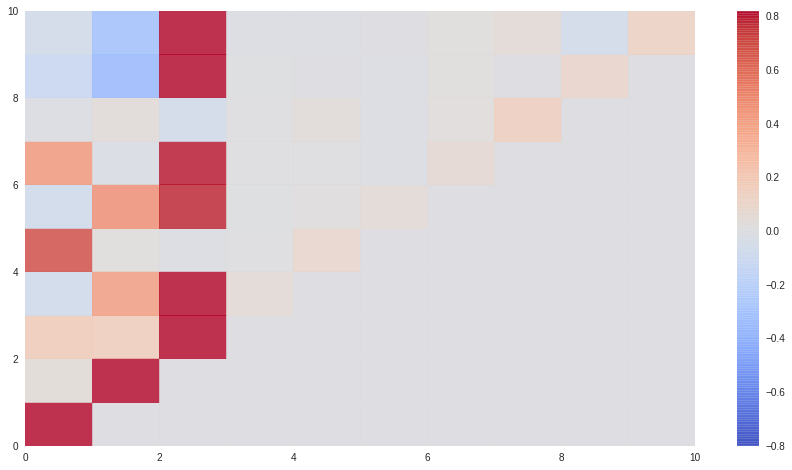

In [37]:
fig, ax = plt.subplots(figsize=(15,8))
im = ax.pcolor(loadings_m2, cmap=plt.cm.coolwarm, alpha=0.8,vmin=loadings.min(),vmax=loadings.max())
fig.colorbar(im);

In [38]:
alpha_m2 = fa_basics.extract(surrogate_trace_df['value'], startswith='alpha', shape=(D,))
alpha_m2

array([   6.37983207,    6.20884548,    1.90079049,  430.37043578,  346.25734884,  375.60779973,  294.24861763,  208.88062085,  191.18956349,  170.53913165])

In [39]:
scale_m2 = np.max(loadings_m2) - np.min(loadings_m2)
np.sum(np.invert(np.isclose(0,loadings_m2,atol=scale_m2*0.1)),axis=0)

array([4, 6, 6, 0, 0, 0, 0, 1, 0, 1])

In [40]:
loadings_m2[:,alpha_m2<15]

array([[ 0.90158014,  0.        ,  0.        ],
       [ 0.04135276,  0.90190546,  0.        ],
       [ 0.17567477,  0.16404415,  0.87451243],
       [-0.07248948,  0.40872751,  0.83573173],
       [ 0.68577325,  0.02204106, -0.00549393],
       [-0.07069945,  0.46127487,  0.77639467],
       [ 0.4301954 , -0.01898762,  0.79878126],
       [-0.01154369,  0.04007155, -0.06537774],
       [-0.12386623, -0.35617234,  0.87795248],
       [-0.06726077, -0.3051443 ,  0.86130449]])

In [41]:
180.0*fa_basics.calc_principal_angles(
    L, loadings_m2[:,alpha_m2<15])/np.pi

array([ 1.9589358 ,  3.69781569,  4.48984012])

Not bad I would say. But most likely also in this case it might be better to run this model first with K=D to determin the number of relevant sub-dimensions and then run the model again with K=relevant-sub-dimensions to force the model to explain all aspects via the sub-dimensions.

# Postprocessing

In [42]:
# http://stackoverflow.com/questions/18024769/adding-custom-styled-paragraphs-in-markdown-cells
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()